In [11]:
import jax.numpy as np
import tree_math
import dataclasses

from jaxsnn.base import funcutils
from jaxsnn.base import implicit
from jaxsnn.tree_solver import ArrayLike, tree_solve, tree_matmul

In [149]:
@tree_math.struct
class HodgekinHuxleyState:
    v: ArrayLike
    m: ArrayLike
    h: ArrayLike
    n: ArrayLike

@tree_math.struct
class HodgekinHuxleyParameters:
    g_K: ArrayLike
    E_K: ArrayLike
    g_Na: ArrayLike
    E_Na: ArrayLike
    g_L: ArrayLike
    E_L: ArrayLike
    C_m_inv: ArrayLike

def alpha_n(Vm):
    return (0.02 * (Vm - 25.0)) / (1.0 - np.exp((-1.0 * (Vm - 25.0)) / 9.0))

def beta_n(Vm):
    return (-0.002 * (Vm - 25.0)) / (1.0 - np.exp((Vm - 25.0) / 9.0))
 
def alpha_m(Vm):
    return (0.182*(Vm + 35.0)) / (1.0 - np.exp((-1.0 * (Vm + 35.0)) / 9.0))
def beta_m(Vm):
    return (-0.124 * (Vm + 35.0)) / (1.0 - np.exp((Vm + 35.0) / 9.0))
 
def alpha_h(Vm):
    return 0.25 * np.exp((-1.0 * (Vm + 90.0)) / 12.0)

def beta_h(Vm): 
    return (0.25 * np.exp((Vm + 62.0) / 6.0)) / np.exp((Vm + 90.0) / 12.0)

# def alpha_n(v):
#     x = (0.02 * (v - 25))
#     y = (1 - np.exp(-(v-25)/9))
#     return x/y
# 
# def alpha_m(v):
#     x = 0.182 * (v + 35.0)
#     y = (1 - np.exp(-(v+35.0)/9.0))
#     return x/y
# 
# def alpha_h(v):
#     return 0.25 * np.exp(-(v+90)/12.0)
# 
# def beta_n(v):
#     x = -0.002 * (v - 25)
#     y = 1 - np.exp((v - 25) / 9.0)
#     return x/y
# 
# def beta_m(v):
#     x = -0.002 * (v - 25)
#     y = 1 - np.exp((v-25)/9)
#     return x/y
# 
# def beta_h(v):
#     return 0.25 * np.exp((v+62)/6.0)/np.exp((v+90)/12.0)

def I_Na(s : HodgekinHuxleyState, p : HodgekinHuxleyParameters):
    return p.g_Na * np.power(s.m,3) * s.h * (s.v - p.E_Na)

def I_K(s : HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_K * np.power(s.n,4) * (s.v - p.E_K)

def I_L(s : HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_L * (s.v - p.E_L)

def channel_dynamics(alpha, beta):
    def dynamics(x : ArrayLike, v : ArrayLike):
        return alpha(v) * (1 - x) - beta(v) * x
    return dynamics

def hodgekin_huxley_dynamics(p : HodgekinHuxleyParameters):
    m_dynamics = channel_dynamics(alpha_m, beta_m)
    h_dynamics = channel_dynamics(alpha_h, beta_h)
    n_dynamics = channel_dynamics(alpha_n, beta_n)

    def dynamics(s : HodgekinHuxleyState, I : ArrayLike):
        return HodgekinHuxleyState(
            v = -p.C_m_inv * (I_K(s, p) + I_Na(s, p) + I_L(s, p) - I),
            m = m_dynamics(s.m, s.v),
            n = n_dynamics(s.n, s.v),
            h = h_dynamics(s.h, s.v)
        )
    return dynamics

$$
\dot{x} = \alpha(v) (1 - x) - \beta(v) x = -\frac{1}{\tau_x(v)} (x - x_0(v))
$$

$$
\tau^{-1}_x(v) = \alpha(v) \beta(v)
$$

$$
\dot{x} = \tau^{-1}_x(v) (x_0(v) - x)
$$

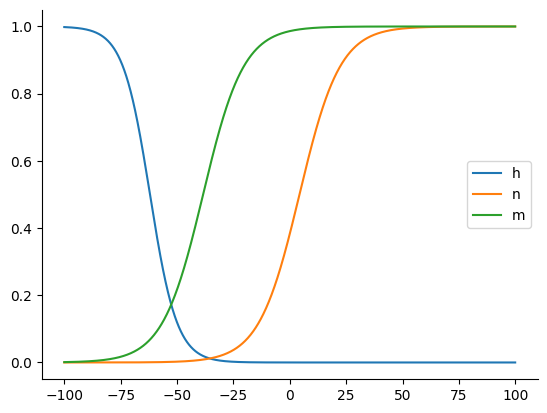

In [150]:
import matplotlib.pyplot as plt

def x0(alpha, beta):
    def x0(v):
        return alpha(v)/(alpha(v) + beta(v))
    return x0

h0 = x0(alpha_h, beta_h)
n0 = x0(alpha_n, beta_n)
m0 = x0(alpha_m, beta_m)

vs = np.arange(-100, 100, 0.1)
plt.plot(vs, h0(vs), label='h')
plt.plot(vs, n0(vs), label='n')
plt.plot(vs, m0(vs), label='m')
plt.legend()

In [151]:
p = HodgekinHuxleyParameters(
    C_m_inv = 1.0, # Inverse Membrane capacitance per unit area (cm^2/uF)
    g_K = 35.0,    # Average potassium channel conductance per unit area (mS/cm^2)
    g_Na = 40.0,   # Average sodoum channel conductance per unit area (mS/cm^2)
    g_L = 0.3,     # Average leak channel conductance per unit area (mS/cm^2)
    E_K = -77.0,   # Potassium potential (mV)
    E_Na = 55.0,   # Sodium potential (mV)
    E_L = -65.0,   # Leak potential (mV)
)

In [152]:
from jaxsnn.base import explicit

def projection(x):
    return x
def output(x,u):
    return x

dynamics = hodgekin_huxley_dynamics(p)
equation = explicit.ExplicitConstrainedCDE(
   explicit_terms=dynamics,
   projection=projection,
   output=output
)

In [156]:
import numpy as onp

initial_state = HodgekinHuxleyState(
    v = p.E_L,
    m = m0(p.E_L),
    n = n0(p.E_L),
    h = h0(p.E_L)
)

dt = 0.01
step_fn = explicit.classic_rk4_cde(equation, dt)

stim = onp.zeros(30000)
stim[7000:30000] = 2.7  # add a square pulse

integrator = funcutils.controlled_trajectory(step_fn, stim)
e, actual = integrator(initial_state, )

TypeError: controlled_trajectory() missing 1 required positional argument: 'xs'

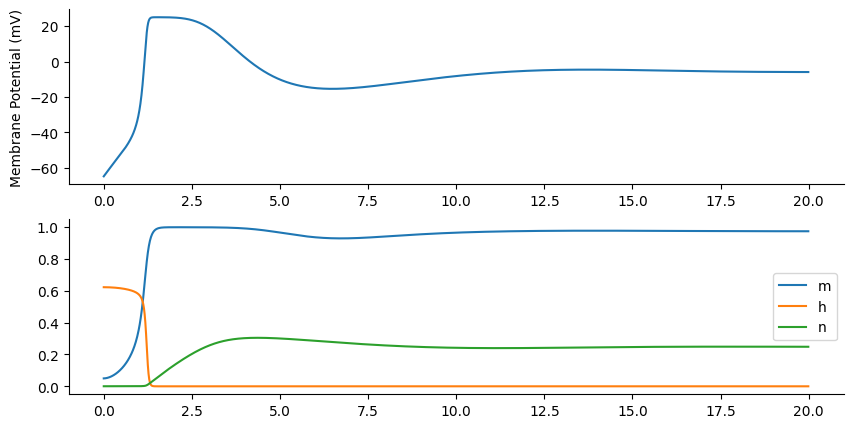

In [155]:
import matplotlib as mpl

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

fig, ax = plt.subplots(2, figsize=(10, 5))

ts = np.arange(0,int(dt*2000), dt)
ax[0].set_ylabel('Membrane Potential (mV)')
ax[0].plot(ts, actual.v)
ax[1].plot(ts, actual.m, label='m')
ax[1].plot(ts, actual.h, label='h')
ax[1].plot(ts, actual.n, label='n')
ax[1].legend()
fig.savefig('figures/hodgekin_huxley_example.png', dpi=300)